# Proposal Abstract
According to the World Health Organization, stroke is the second leading cause of death globally. Thus, our group thinks that predicting the probability of getting a stroke in advance and interfering in time is crucial. In this project, we will train models with the dataset Stroke Prediction Dataset (https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) using logistic regression, LDA, KNN and other possible models to predict whether a patient would get stroke.

We would like to build a classifier that can predict the onset of stroke with high accuracy (hopefully near 90%). The takeaway of our project is that we hope the features which constitute our most accurate classifier can serve as precautionary factors in preventing stroke with some grain of truth.

After thorough consideration and discussion among project partners, we believe it is better to use supervised learning methods since our data has clear labels (get stroke/ does not get stroke). In addition, as the prediction of our prediction is categorical, consisting of exactly two categories, we recognize that building a classifier via logistic regression should be the most appropriate approach in addressing the dataset and our project's interest.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

# Brief Data Visualization and Simple Exploratory Analysis
We would like to first double-check that our dataset doesn't violate any basic assumptions about logistic regression, such as multi-colinearity, extreme outliers, homoscedasticity, etc..

In [2]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.set_index('id', inplace = True)
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


/Users/Muchan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/Muchan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/Muchan/opt/anaconda3/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/Muchan/opt/anaconda

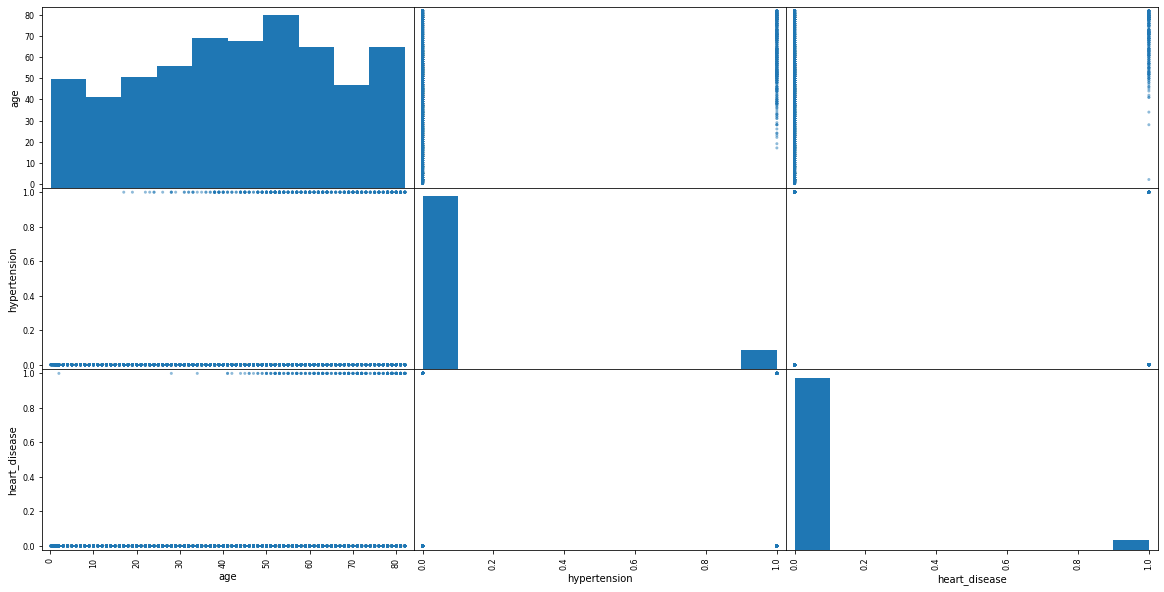

In [3]:
overview_1 = pd.plotting.scatter_matrix(data.iloc[:, :6], figsize = (20, 10))

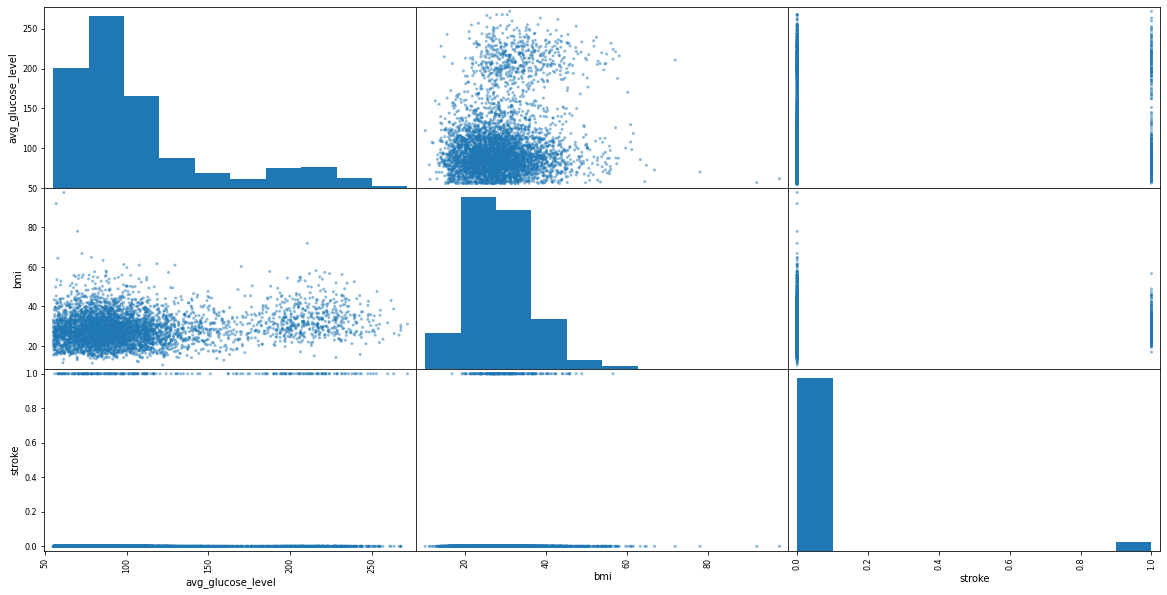

In [4]:
overview_2 = pd.plotting.scatter_matrix(data.iloc[:, 6:], figsize = (20, 10))

In [5]:
data.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

So far what we've noticed are:

1. There are 5 predictor variables that are stored as strings, which would require us to convert them first to dummy variables.
2. There are 201 missing observations from the "bmi" column. We would have to either remove these observations and somehow compensate for the missing values before proceeding to building our model. In addition, as it is noted on Kaggle, where our dataset is published from, the "unknown" entries in "smoking status" also means that the information was unavailable, i.e. NaN, from the patient. We then need to account for this, too.
3. Our scatter matrix shows that our dataset does not violate the assumptions to performing logistic regression.

In [6]:
data.dropna(inplace = True) # Drop the N/A values from bmi.
data = data[data['smoking_status'] != 'Unknown'] # Drop the Unknown values from smoking status.
data

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
68398,Male,82.0,1,0,Yes,Self-employed,Rural,71.97,28.3,never smoked,0
45010,Female,57.0,0,0,Yes,Private,Rural,77.93,21.7,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0


# Encoding Categorical Predictor Variables into Dummy Variables    

In [7]:
print(data['gender'].unique(), 
      data['ever_married'].unique(),
      data['work_type'].unique(),
      data['Residence_type'].unique(),
      data['smoking_status'].unique()
     )

['Male' 'Female' 'Other'] ['Yes' 'No'] ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked'] ['Urban' 'Rural'] ['formerly smoked' 'never smoked' 'smokes']


We have five categorical variables. 

Two of which, `ever_married` and `Residence type`, are binary and we will encode them conventionally using 0's and 1's.

Of all the other non-binary categorical variables, we will have to create k - 1 dummy variables to represent them numerically, where k is each of their numbers of different levels.

In [8]:
# This section of code is borrowed from:
# https://medium.com/@urvashilluniya/convert-multiple-categorical-columns-into-numeric-columns-in-single-line-of-code-577bab825635
data_dummies = pd.get_dummies(data, columns = ['gender',
                                               'ever_married',
                                               'work_type',
                                               'Residence_type',
                                               'smoking_status'
                                              ], 
                              drop_first = True
                             )
data_dummies

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
id,,,,,,,,,,,,,,,,
9046,67.0,0,1,228.69,36.6,1,1,0,1,0,1,0,0,1,0,0
31112,80.0,0,1,105.92,32.5,1,1,0,1,0,1,0,0,0,1,0
60182,49.0,0,0,171.23,34.4,1,0,0,1,0,1,0,0,1,0,1
1665,79.0,1,0,174.12,24.0,1,0,0,1,0,0,1,0,0,1,0
56669,81.0,0,0,186.21,29.0,1,1,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68398,82.0,1,0,71.97,28.3,0,1,0,1,0,0,1,0,0,1,0
45010,57.0,0,0,77.93,21.7,0,0,0,1,0,1,0,0,0,1,0
44873,81.0,0,0,125.20,40.0,0,0,0,1,0,0,1,0,1,1,0


In [9]:
# kf = KFold(n_splits = 5, shuffle = True, random_state = 109)